# Exercise 2 - Data Preparation

You should have completed exercise 1 before this exercise.

We use the same dataset "train_FD001.txt" as in exercise 1. You can download it from moodle. 
In this exercise we focus on the data preparation. Data preparation typically is the most time-consuming task in machine learning and data mining tasks. It is fundamental to prepare the raw data to be processable by algorithms. Next to outlier removal and filtering and smoothing of the data, feature generation (e.g. Fourier Transformation) or feature reduction (e.g. Principal Component Analysis, PCA) can be applied. 

In this exercise, we will analyse the influence of basic filtering (moving average) and feature reduction methods (PCA) on the correlations of variables with the RUL.

First we load basic libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. Load your data, rename columns if you wish to.

In [2]:
# load data
train_path = "train_FD001.txt"
df = pd.read_csv(train_path, sep=" ", header=None)

# dropping dolumns with no values
df = df.drop(columns=[26,27])

# rename the columns with the parameter names
data_header = {0: 'Engine', 1: 'Cycle', 2: 'Altitude', 3: 'MachNumber', 4: 'TRA', 5: 'T2', 6: 'T24', 7: 'T30', 8: 'T50', 9: 'P2', 10: 'P15', 11: 'P30', 12: 'Nf', 13: 'Nc', 14: 'epr', 15: 'Ps30', 16: 'phi', 17: 'NRf',
               18: 'NRc', 19: 'BPR', 20: 'farB', 21: 'htBleed', 22: 'Nf_dmd', 23: 'PCNfR_dmd', 24: 'W31', 25: 'W32'}
df = df.rename(columns=data_header)

### 2. Choose one of the variables with high RUL-correlation from exercise 1 and apply a moving average filter with window sizes of 5, 10 and 20 time steps.  Plot the results and compare it with the unfiltered signal.

In [3]:
# calculate maximum cycles per engine
df_max_cycles = df[['Engine', 'Cycle']].groupby(['Engine']).max()
df_max_cycles = df_max_cycles.rename(columns={'Cycle': 'Max_Cycles'})

# merge the max_cycles value to the dataframe
df = df.merge(df_max_cycles, left_on='Engine', right_index=True)

# calculation of remaining useful life
df['RUL'] = df['Max_Cycles'] - df['Cycle']

As seen in the last exercise, we have the highest positive correlations:
- Nc and NRc: 0.96
- Nf and NRf: 0.83
- T50 and Ps30: 0.83
- P30 and phi: 0.81

And the highest negative correlations:
- Ps30 and phi: -0.85
- P30 and Ps30: -0.82
- T50 and phi: -0.82

In [4]:
df['W31_SMA05'] = df['W31'].rolling(5).mean()
df['W31_SMA10'] = df['W31'].rolling(10).mean()
df['W31_SMA20'] = df['W31'].rolling(20).mean()

Text(0, 0.5, 'W31')

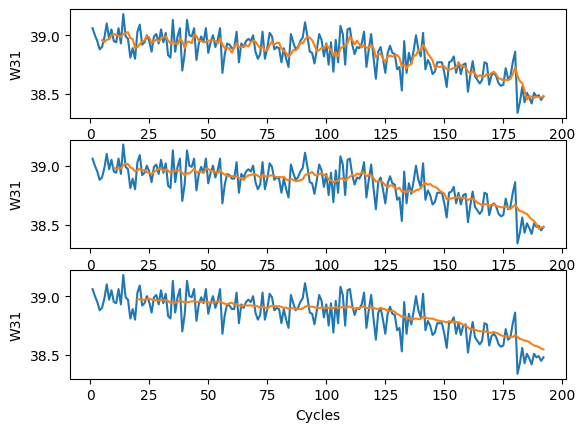

In [5]:
engine = 1
plt.figure()

df_engine = df[df['Engine'] == engine]
plt.subplot(3,1,1)
plt.plot(df_engine['Cycle'], df_engine['W31']) # non-filtered
plt.plot(df_engine['Cycle'], df_engine['W31_SMA05']) # 5 steps moving average
plt.xlabel('Cycles')
plt.ylabel('W31')

plt.subplot(3,1,2)
plt.plot(df_engine['Cycle'], df_engine['W31']) # non-filtered
plt.plot(df_engine['Cycle'], df_engine['W31_SMA10']) # 10 steps moving average
plt.xlabel('Cycles')
plt.ylabel('W31')

plt.subplot(3,1,3)
plt.plot(df_engine['Cycle'], df_engine['W31']) # non-filtered
plt.plot(df_engine['Cycle'], df_engine['W31_SMA20']) # 20 steps moving average
plt.xlabel('Cycles')
plt.ylabel('W31')

### 3. Compare correlations of the filtered sensor signal with the RUL and the raw signal with the RUL. What can you conclude from the results?

In [6]:
target_correlation = df.corr(method='pearson')
target_correlation = target_correlation.loc['RUL']
target_correlation

Engine        0.078753
Cycle        -0.736241
Altitude     -0.003198
MachNumber   -0.001948
TRA                NaN
T2                 NaN
T24          -0.606484
T30          -0.584520
T50          -0.678948
P2                 NaN
P15          -0.128348
P30           0.657223
Nf           -0.563968
Nc           -0.390102
epr                NaN
Ps30         -0.696228
phi           0.671983
NRf          -0.562569
NRc          -0.306769
BPR          -0.642667
farB               NaN
htBleed      -0.606154
Nf_dmd             NaN
PCNfR_dmd          NaN
W31           0.629428
W32           0.635662
Max_Cycles    0.363152
RUL           1.000000
W31_SMA05     0.670507
W31_SMA10     0.616101
W31_SMA20     0.495541
Name: RUL, dtype: float64

As we can see, the correlation between RUL and W31 went up when the 5 steps moving average was applied. It's also important to notice that it went down when more agressive moving averages were used, namely with 10 and 20 steps.

### 4. Fit and apply a PCA on the sensor subset. Remember to standardize the data first. Plot the first two Principal Components against each other.
Hint: Libraries like Scikit Learn include suitable functions.  

In [7]:
# getting to know which is wich
opcond = ['Engine', 'Cycle', 'Max_Cycles', 'Altitude', 'MachNumber', 'RUL']
sensors = df.columns.drop(opcond)

# separating the data
df_sensors = df.drop(columns=opcond) # getting the sensor subset
df_opcond = df.drop(columns=sensors) # getting the operation conditions subset

In [19]:
from sklearn.preprocessing import StandardScaler

# standardizing the data
scaler = StandardScaler()
scaler.fit(df_sensors)
df_sensors_scaled = pd.DataFrame(scaler.transform(df_sensors)).dropna()
df_scaled = df_opcond.merge(df_sensors_scaled, left_on='Engine', right_index=True)

Text(0.5, 0, 'Second principal component')

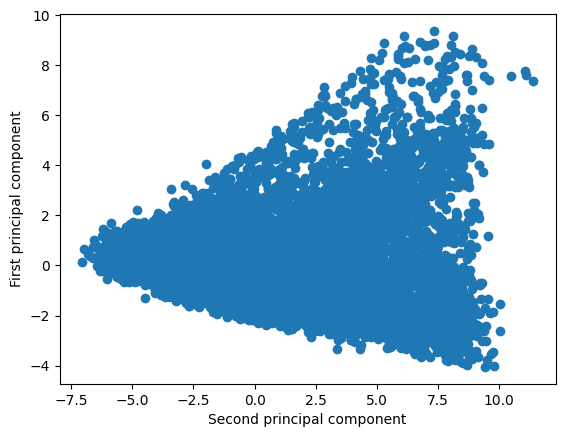

In [24]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=df_sensors_scaled.shape[1])
pca_full.fit(df_sensors_scaled)
df_sensors_pca = pca_full.transform(df_sensors_scaled)

plt.figure()
plt.scatter(df_sensors_pca[:,0], df_sensors_pca[:,1])
plt.ylabel("First principal component")
plt.xlabel("Second principal component")

In [9]:
#https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0df_sensors_scaled

### 5. How much variance is explained by the first principal component?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  float64
 1   1       20631 non-null  float64
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  float64
 22

### 6. How many principal components are needed to explain more than 95% of the variance in the data?

### 7. Analyse the correlation of the principal components with the RUL. Does the result meet your expectations?

### 8. Which sensors have the highest feature importance in first principal components? How does this relate to the correlations with RUL from exercise 1?